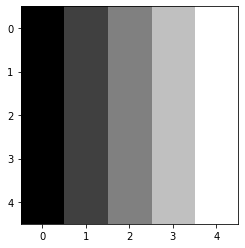

In [29]:
import matplotlib.pyplot as plt
import numpy as np

test = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
plt.imshow(test, cmap="gray")
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from cv import Cadence
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import ReLU, Conv2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from ignite.metrics import Recall, Precision, Accuracy

### Config

In [31]:
conf_dict = {
    "batch_size": 32,
    "learn_rate": 1e-3,
    "epochs": 5,

    "train_dir": "../data/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../data/test/",
    "test_csv": "sample_submission.csv",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "random_seed": 10,

    "only_use": 1000,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


### Custom Dataset

In [32]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, img_dir, test=False, transform=None, target_transform=None, use_cv=False):
		self.test = test
		if not self.test:
			self.img_labels = pd.read_csv(img_dir + conf_dict["train_csv"])
		else:
			self.img_labels = pd.read_csv(img_dir + conf_dict["test_csv"])
		self.img_labels['file_path'] = self.img_labels['id'].apply(self.get_file_path, dir=img_dir)
		self.img_dir = img_dir
		self.file_names = self.img_labels['file_path'].values
		self.transform = transform
		self.target_transform = target_transform
		self.use_cv = use_cv

	def __len__(self):
		return len(self.img_labels)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		if self.use_cv:
			cadence = Cadence(file_path)
			cadence.cv()

		image = np.vstack(image).T

		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()

		label = torch.tensor(self.img_labels["target"][idx])#.float()
		return image, label

	def get_file_path(self, image_id, dir):
		return dir + "{}/{}.npy".format(image_id[0], image_id)


In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4 * 128 * 128, 32),
            nn.ReLU(),
            BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            BatchNorm1d(32),
            nn.Linear(32, 1),
        )
        self.simple_cnn_stack = nn.Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.simple_cnn_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x).squeeze()
        # y_pred = torch.sigmoid(x).squeeze()
        return logits


In [34]:
class SETITrainValidation():
    def __init__(self, train_dir, test_dir, load_model=False, val_split=0.25):
        self.dataset_whole_train = SETIDataset(train_dir, transform=self.get_transforms(data="train"))#, use_cv=True)
        self.dataset_whole_val = SETIDataset(train_dir, transform=self.get_transforms(data="val"))#, use_cv=True) # extra dataset für validation, da validation data nicht transformiert werden darf
        # self.dataset_test = SETIDataset(test_dir, test=True, transform=self.get_transforms(data="test"), use_cv=True)
        if load_model:
            self.model = self.load_model()
        else:
            self.model = self.new_model()
        self.loss_fn = nn.BCEWithLogitsLoss().to(device) # nn.BCELoss().to(device) => needs sigmoid as last layer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=conf_dict["learn_rate"])
        self.val_split = val_split
        self.train_dataloader = None
        self.val_dataloader = None
        self.train_losses = []
        self.train_acc = []
        self.val_losses = []
        self.val_acc = []
        self.accuracy = Accuracy()
        self.precision = Precision()
        self.recall = Recall()


    def get_transforms(self, data):
        if data == 'train':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                A.VerticalFlip(p = 0.5),
                A.HorizontalFlip(p = 0.5),
                ToTensorV2()
            ])
        elif data == 'val' or data == 'test':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                ToTensorV2()
            ])

    def split(self, shuffle=True, use_all=True):
        dataset_whole_size = len(self.dataset_whole_train)
        if use_all:
            indices = list(range(dataset_whole_size))
            split = int(np.floor(self.val_split * dataset_whole_size))
        else:
            indices = list(range(conf_dict["only_use"]))
            split = int(np.floor(self.val_split * conf_dict["only_use"]))

        if shuffle:
            np.random.seed(conf_dict["random_seed"])
            np.random.shuffle(indices)

        train_indices, val_indices = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        self.train_dataloader = DataLoader(self.dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)#, num_workers=2)
        self.val_dataloader = DataLoader(self.dataset_whole_val, batch_size=conf_dict["batch_size"], sampler=val_sampler)#, num_workers=2)

        print(f"Successfully splitted dataset!\n Trainbatches: {len(self.train_dataloader)}\n Validationbatches: {len(self.val_dataloader)}")
    
    def train_loop(self):
        print("Starting model training...")
        num_batches = len(self.train_dataloader)
        test_loss = 0
        for batch, (image, label) in enumerate(self.train_dataloader):
            # print(f"batch {batch}/{num_batches}")
            image = image.to(device)
            label = label.to(device)
            pred = self.model(image)
            loss = self.loss_fn(pred, label.to(torch.float32))
            test_loss += loss.item()

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            predicted = torch.sigmoid(pred).round().int()
            self.accuracy.update((predicted, label))
            self.precision.update((predicted, label))
            self.recall.update((predicted, label))

            if batch % 100 == 0:
                loss = loss.item()
                self.train_losses.append(loss)
                self.train_acc.append(100*self.accuracy.compute())
        print(f"""Test Error: \n 
            Accuracy: {100*self.accuracy.compute()}%, \n
            Recall: {100*self.recall.compute()}%, \n
            Precision: {100*self.precision.compute()}%, \n
            Avg loss: {test_loss/num_batches:>8f} \n
        """)

    def validation_loop(self):
        print("Starting model validation...")
        num_batches = len(self.val_dataloader)
        test_loss = 0

        with torch.no_grad():
            for batch, (image, label) in enumerate(self.val_dataloader):
                # print(f"batch {batch}/{num_batches}")
                image = image.to(device)
                label = label.to(device)
                pred = self.model(image)
                loss = self.loss_fn(pred, label.to(torch.float32)).item()
                test_loss += loss

                predicted = torch.sigmoid(pred).round().int()

                self.accuracy.update((predicted, label))
                self.precision.update((predicted, label))
                self.recall.update((predicted, label))

                if batch % 100 == 0:
                    self.val_losses.append(loss)
                    self.val_acc.append(100*self.accuracy.compute())
        print(f"""Test Error: \n 
            Accuracy: {100*self.accuracy.compute()}%, \n
            Recall: {100*self.recall.compute()}%, \n
            Precision: {100*self.precision.compute()}%, \n
            Avg loss: {test_loss/num_batches:>8f} \n
        """)

    def load_model(self):
        self.model = self.new_model()
        self.model.load_state_dict(torch.load(conf_dict["model"]))
        self.model.eval()

    def save_model(self):
        print("Training done! Saving model...")
        torch.save(self.model.state_dict(), conf_dict["model"])
        print("Saved model")

    def new_model(self):
        return NeuralNetwork().to(device)

    def plot_loss_acc_vs_epochs(self, train=True, plot_loss=True):
        if train:
            if plot_loss:
                vs = "Loss"
                plt.plot(self.train_losses, "ro-")
            else:
                vs = "Accuracy"
                plt.plot(self.train_acc, "ro-")
        else:
            if plot_loss:
                vs = "Loss"
                plt.plot(self.val_losses, "ro-")
            else:
                vs = "Accuracy"
                plt.plot(self.val_acc, "ro-")
        plt.title(vs + " vs Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(vs)
        plt.show()

    def train_model(self):
        num_epochs = conf_dict["epochs"]
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
            self.train_loop()
        self.plot_loss_acc_vs_epochs(train=True, plot_loss=True)
        self.plot_loss_acc_vs_epochs(train=True, plot_loss=False)
        self.save_model()

    def validate_model(self):
        self.load_model()
        num_epochs = conf_dict["epochs"]
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
            seti_trainer.validation_loop()
        self.plot_loss_acc_vs_epochs(train=False, plot_loss=True)
        self.plot_loss_acc_vs_epochs(train=False, plot_loss=False)
        

In [35]:
seti_trainer = SETITrainValidation(conf_dict["train_dir"], conf_dict["test_dir"], load_model=False)
seti_trainer.split(use_all=True)
seti_trainer.train_model()
# seti_trainer.validate_model()

Successfully splitted dataset!
 Trainbatches: 24
 Validationbatches: 8
Epoch 1/5
-------------------------------
Starting model training...
Test Error: 
 
            Accuracy: 51.46666666666667%, 

            Recall: 50.0%, 

            Precision: 10.164835164835164%, 

            Avg loss: 0.708033 

        
Epoch 2/5
-------------------------------
Starting model training...


KeyboardInterrupt: 